# Exploratory Data Analysis
This Notebook is dedicated to performing the data analysis of the variables that describe the dataset. This script will perform data exploration, as well feature engineering taking example from the physics knwon for the problem. Note that the data visualization aspect is mainly done trough plotly. 

### IMPORTANT:

In order to visualize plotly's plots in jupyter, you need to have nodejs installed, as well as the correct extension for jupyter lab. For more info follow https://ipywidgets.readthedocs.io/en/latest/user_install.html on how to install all the required packages.

In [1]:
import pandas as pd
import numpy as np
from script import utils #Custom utils file

2021-09-02 08:46:19.271740: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-02 08:46:19.271771: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Data visualization libraries used (I personally prefer plotly, but I can use all three)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

For train-test split of the data. (The shuffle method from stratifiedKfold is at times unsatisfactory, hence I will shuffle the data beforehand to assure a proper mix)

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [4]:
df_b = pd.read_csv('Data/Dataset.csv') #Load the RAW dataset
df_b.head()

,Author,P,T,Type of liquid,Type of Gas,DenL,DenG,VisL,VisG,ST,ID,Roughness,Ang,L/D,Vsl,Vsg,Flow_label
0,1985_Piu-,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.000015,0.07,0.0254,0,0.0,600.0,0.044817,0.814024,SW
1,1985_Piu-,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.000015,0.07,0.0254,0,0.0,600.0,0.060976,0.814024,I
2,1985_Piu-,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.000015,0.07,0.0254,0,0.0,600.0,0.088110,0.814024,I
3,1985_Piu-,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.000015,0.07,0.0254,0,0.0,600.0,0.060976,1.103659,I
4,1985_Piu-,100.0,20.0,Water,Air,1000.0,1.12,0.001,0.000015,0.07,0.0254,0,0.0,600.0,0.121951,1.103659,I


In [5]:
df_b = shuffle(df_b, random_state=1)
df_b.reset_index(drop=True, inplace=True)
df_b.head()

,Author,P,T,Type of liquid,Type of Gas,DenL,DenG,VisL,VisG,ST,ID,Roughness,Ang,L/D,Vsl,Vsg,Flow_label
0,2001_Mata,100.0,25.0,Oil,Air,879.8,1.30,0.483,0.000018,0.03,0.0508,0,0.0,NaN,0.010940,8.033540,SW
1,1982_Ovad,100.0,25.0,Water,Air,1000.0,1.18,0.001,0.000015,0.07,0.0250,0,-5.0,NaN,2.500000,0.630000,DB
2,2001_Mata,100.0,25.0,Oil,Air,879.8,1.30,0.483,0.000018,0.03,0.0508,0,0.0,NaN,1.339250,3.470902,I
3,1982_Ovad,100.0,25.0,Water,Air,1000.0,1.18,0.001,0.000015,0.07,0.0510,0,-1.0,NaN,1.800000,0.025000,DB
4,1982_Ovad,100.0,25.0,Water,Air,1000.0,1.18,0.001,0.000015,0.07,0.0250,0,-90.0,NaN,0.986322,0.021483,I


Define features and target columns

In [6]:
target = 'Flow_label'
features_b = df_b.columns.drop(target) #Bronze features

## Train Test Splitting

The first and most important part of the analysis, to avoid information leakage (and hence optimistic expectations) is to split the data between training and testing. Since we are dealing with a classification problem, stratified k fold is applied to the labels in order to preserve the original distribution in both training and testing

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #SKF
train_idx, test_idx = next(skf.split(df_b[features_b].values, df_b[target].values.ravel())) #Get the split
df_b, df_b_test = df_b.loc[train_idx].reset_index(drop=True), df_b.loc[test_idx] #Train, Test

We now save the bronze (unprocessed) data in the right folder. No reasonable infomration leakage can now happen between training and testing now

In [8]:
df_b_test.to_csv('Data/Test_bronze.csv', index=False)

## Null Values and Variables Distribution

We can now properly analyze the data, fist by checking for missing values, and then by exploring variables distributions

In [9]:
Null_values = df_b.isnull().mean()[df_b.isnull().mean()!=0]
Null_values

L/D    0.739285
dtype: float64

It is clear that most of the data related to the lenght of the pipe is missing. While some argument could be made about treating this variable as a categorical and mean encode it, to keep the model relaviely simple, it will be removed in the following step (in the tranformation of the data from bronze to silver)

## Basic Quantities Distribution

We can now look at the shape of the data, looking for distributions and possible outliers, that need to be removed. 

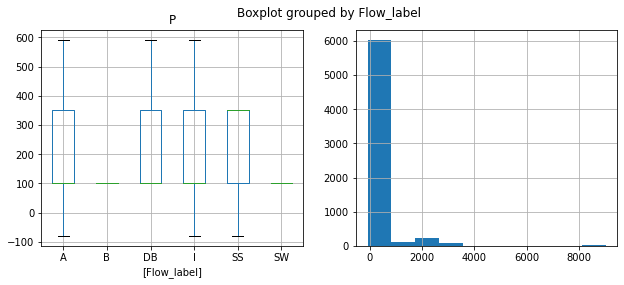

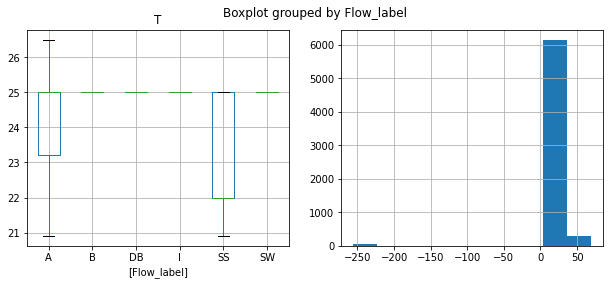

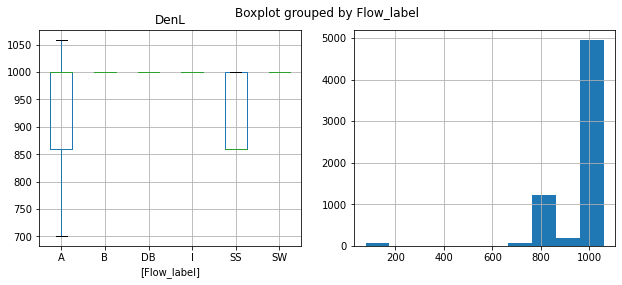

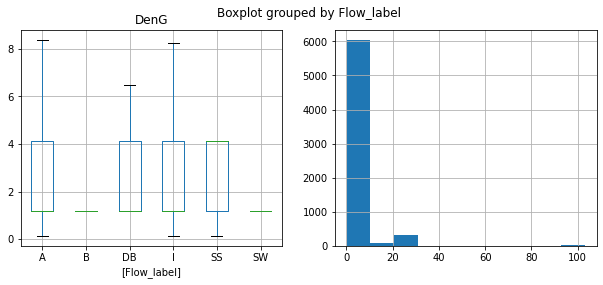

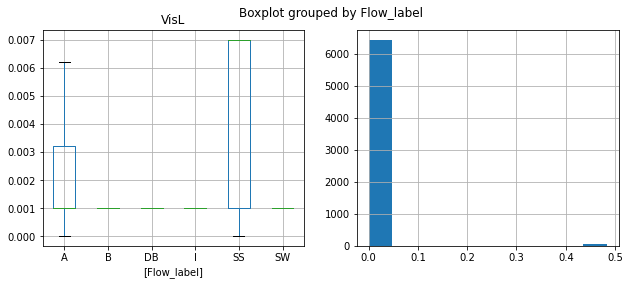

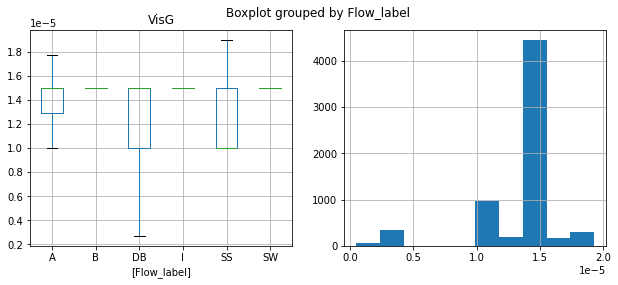

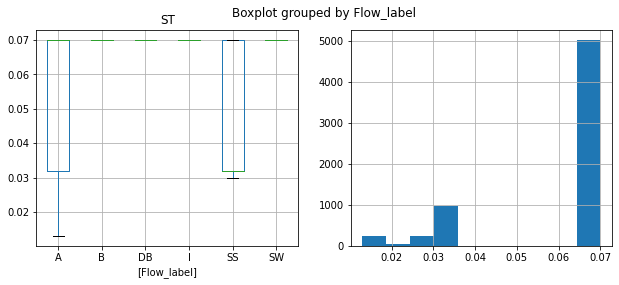

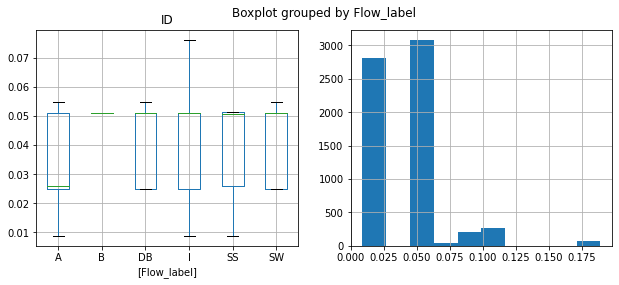

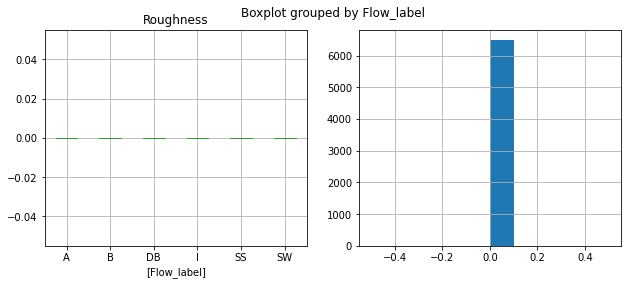

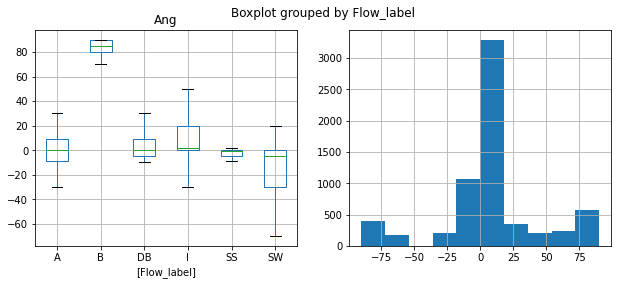

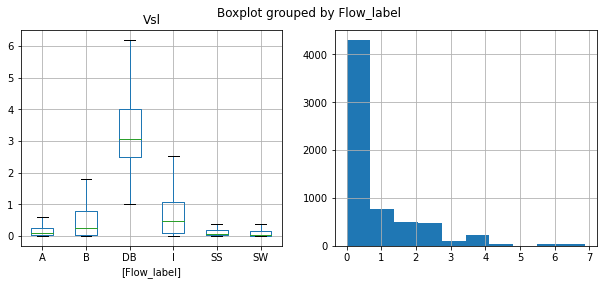

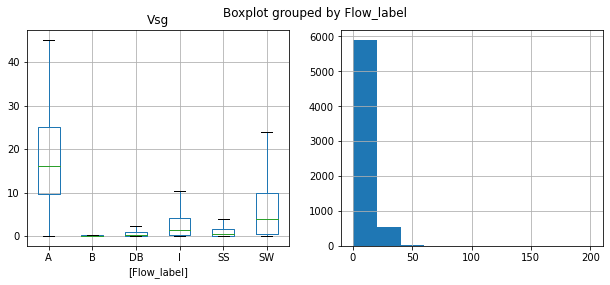

In [10]:
df_s = utils.bronze_to_silver(df_b)
plt.rcParams.update({'figure.max_open_warning': 0}) #Stop yelling about max figures
for quantity in df_s.columns[0:-1]:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))      
    df_b[[quantity, target]].boxplot(by=target, showfliers=False, ax=axes[0])
    df_s[quantity].hist(bins=10)
    fig.savefig(f'Plots/BoxPlots/{quantity}.png', dpi=fig.dpi, bbox_inches='tight')

## Target Distribution

We see that the data is far from being evenly distribuited. The next step is to assess weather the target is balanced or not

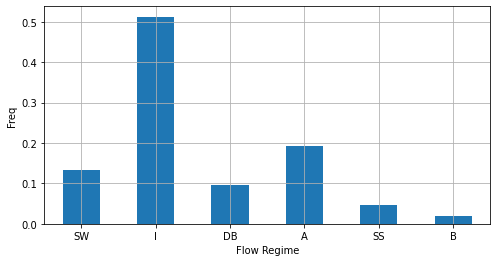

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))   

out_norm = df_b[target].value_counts(sort=False, normalize=True).mul(1)
out_norm.plot.bar(rot=0)
axes.set_ylabel("Freq")
axes.set_xlabel("Flow Regime")
axes.grid()

plt.show()
fig.savefig(f'Plots/Others/Flow_regimes.png', dpi=fig.dpi, bbox_inches='tight')

There is a strong imbalance between the labels, the intermittent flow regime cover more than half the data. During training, oversampling technqiues will be required to improve the detection of the minority classes

## Feature Engineering

Once we have analyzed the various distribution, we see that feature engineering will be required to better separate the various classes. This is fundamental in tree based models like RandomForest and LightGBM. Additionally, to improve generability (sacrificng performance on this specific dataset) dimensionless quantities will replace dimensional quantities previously analyzed

In [13]:
df_g = utils.silver_to_gold(df_s) #Gold data (Ready to be processed)
features_g = df_g.columns.drop(target) #Gold features
df_g.head()

,Ang,ReL,ReG,FrL,FrG,NL,X_LM,X_LM_2,Y,We,Eo,HU,K_G,T_TB,Flow_label
0,0.0,1.012357,28677.566573,0.015512,0.437840,0.061667,4.209577,17.720538,0.000000,0.178317,741.086004,0.399677,0.440537,0.007606,3
1,-1.0,91800.000000,100.300000,2.546733,0.001215,0.074847,154.230545,23787.060986,-37052.910726,2360.571429,363.957118,0.822310,0.368140,0.011204,1
2,-90.0,24658.050000,42.249703,1.993172,0.001491,0.067897,73.985127,5473.799000,-593681.859140,347.439674,87.456055,0.209673,0.234174,0.009220,2
3,0.0,5100.000000,64192.000000,0.141485,0.777628,0.005925,0.249522,0.062261,0.000000,7.285714,363.957118,0.083195,55.533754,0.000070,0
4,90.0,39340.500000,1902.441233,3.179991,0.067150,0.102559,16.654133,277.360143,13184.576734,884.385680,87.456055,0.874326,13.318873,0.021037,2


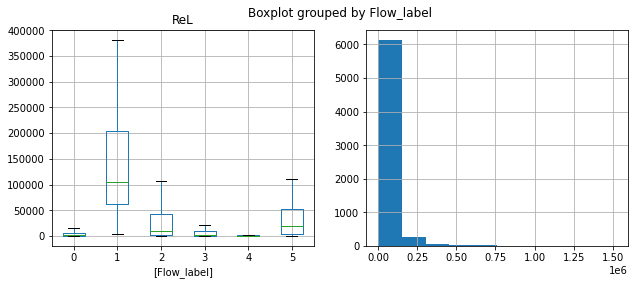

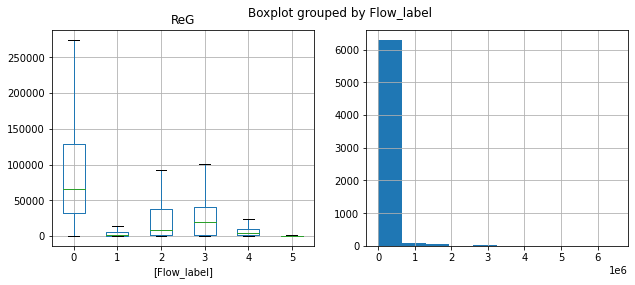

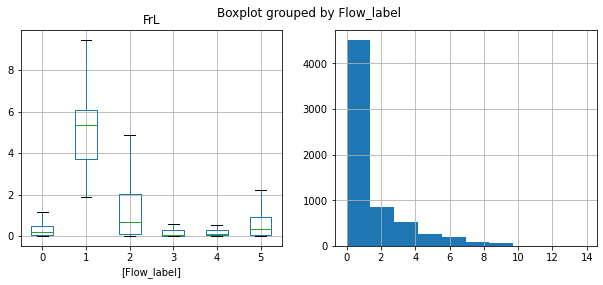

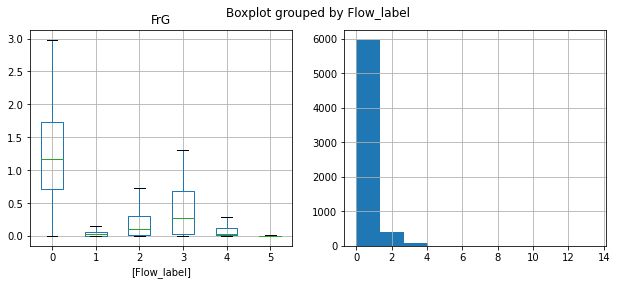

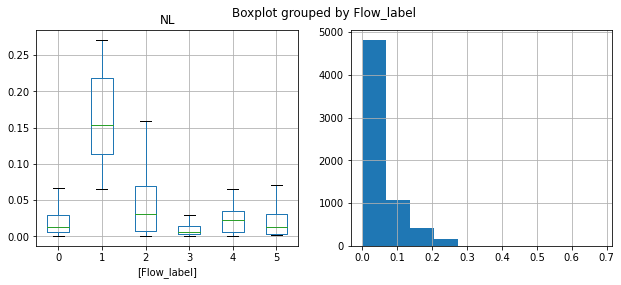

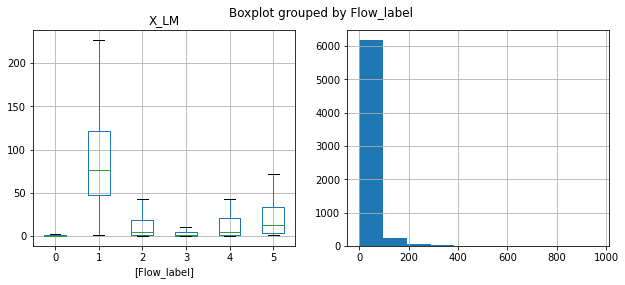

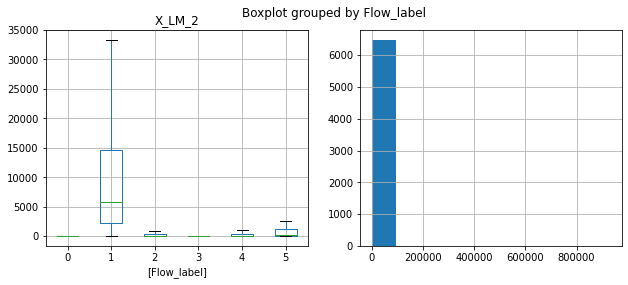

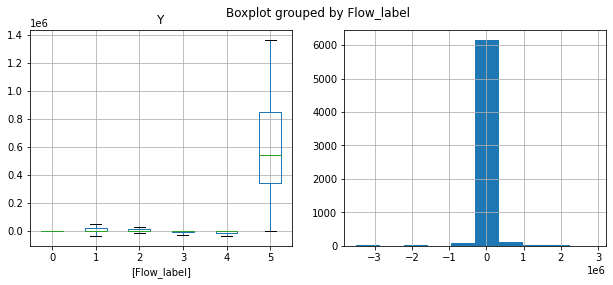

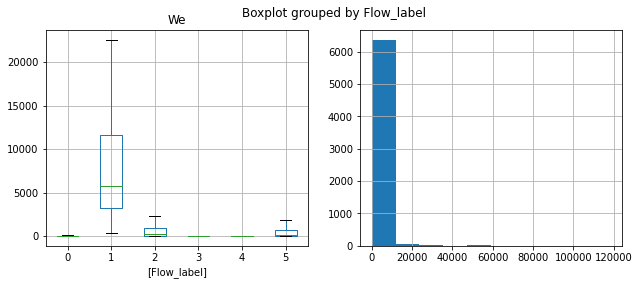

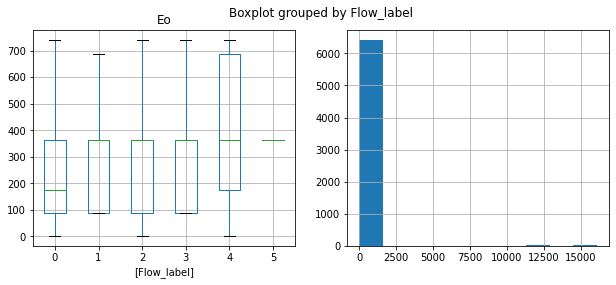

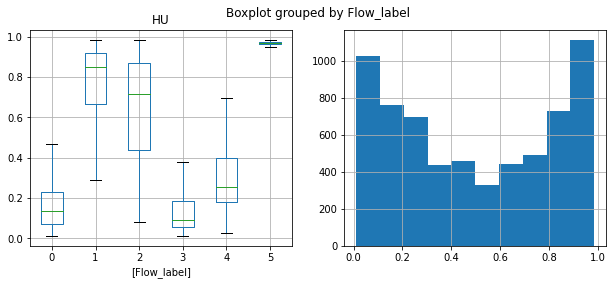

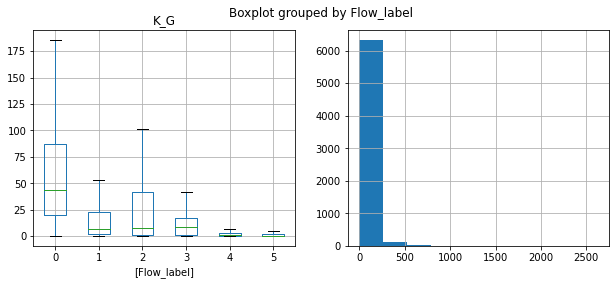

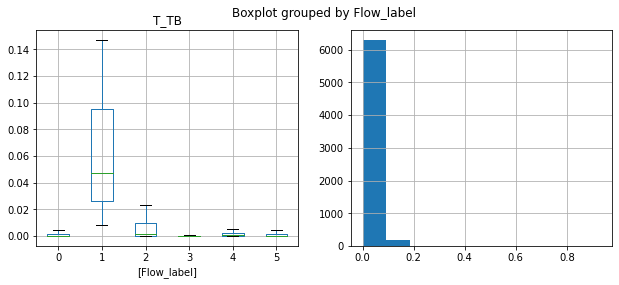

In [14]:
new_features = [x for x in df_g.columns if x not in set(df_s.columns)]

for quantity in new_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) 
    df_g[[quantity, target]].boxplot(by=target, showfliers=False, ax=axes[0])
    df_g[quantity].hist(bins=10)
    fig.savefig(f'Plots/BoxPlots/{quantity}.png', dpi=fig.dpi, bbox_inches='tight')

## Log-Quantities

Excluding the liquid goldup HU, many of the engineered features are actually hard to visualize due to their scale. Where possible, logarithm will be applied to better show their importance

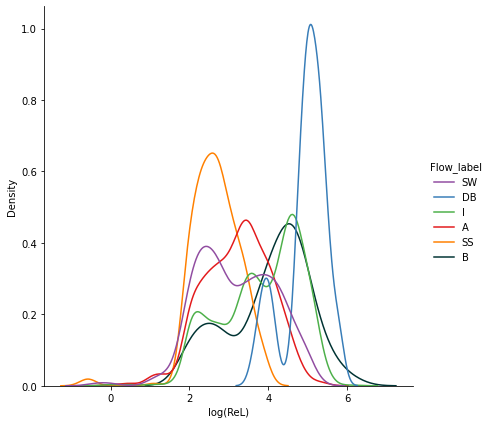

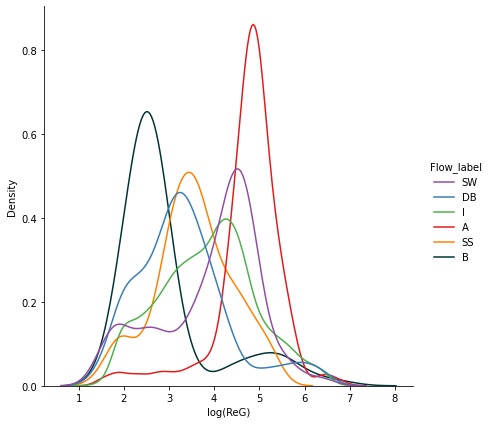

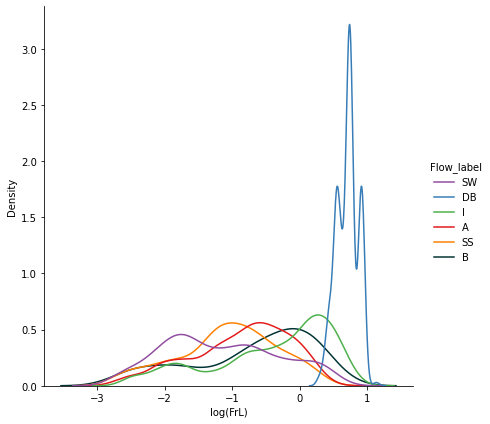

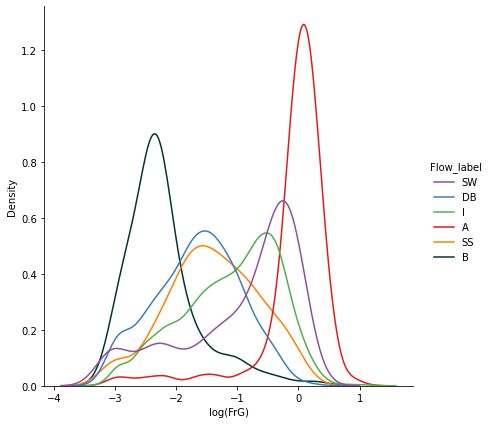

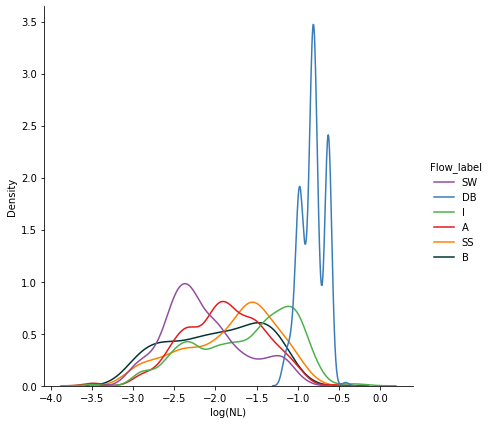

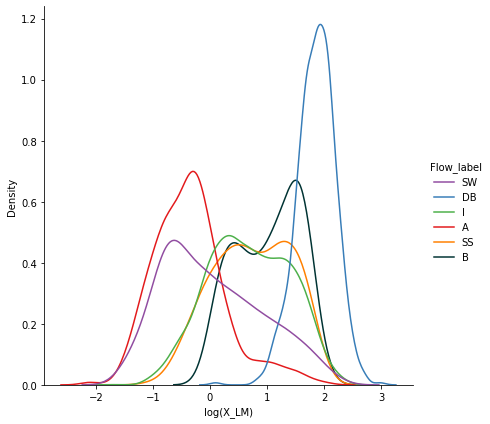

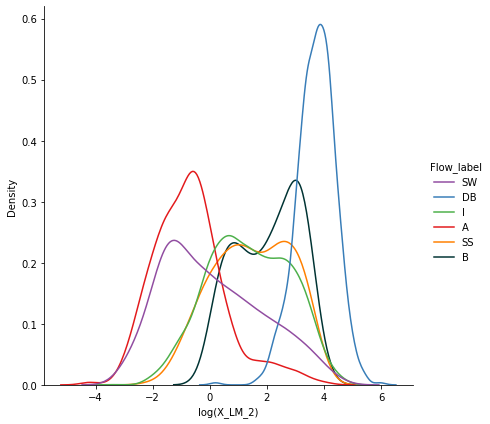

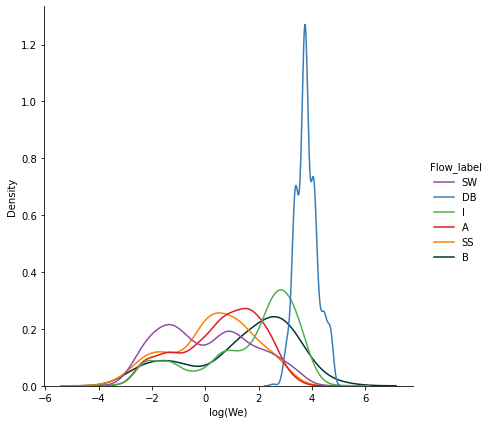

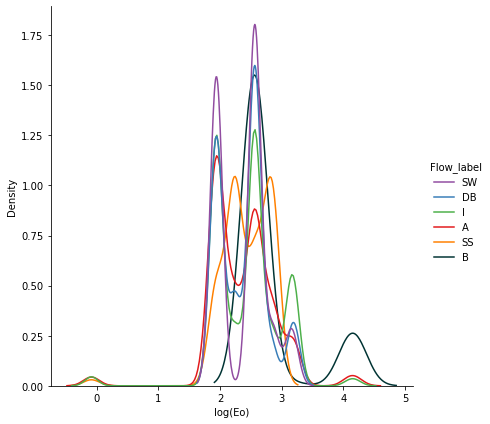

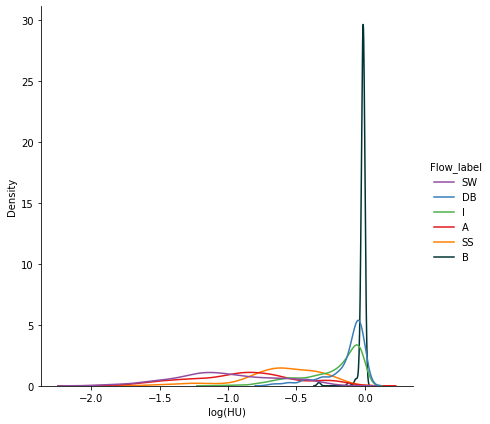

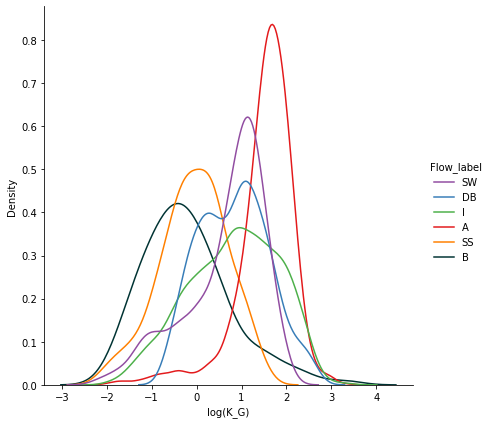

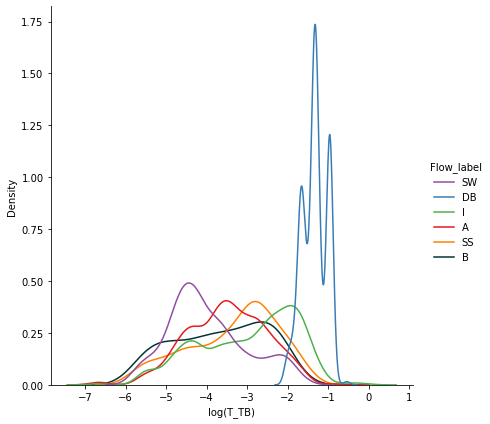

In [17]:
#Define custom color pallet
di = {'A':[0.89,0.1,0.11], 
      'DB':[0.22,0.49,0.72], 
      'I':[0.3,0.69,0.29], 
      'SW':[0.57,0.3,0.63], 
      'SS':[1,0.5,0], 
      'B':[0,0.2,0.2]
     }

log_q = [q for q in df_g[features_g].columns if df_g[q].min()>=0]

df_log = pd.DataFrame(df_b[target], columns=[target])
for q in log_q:   
    df_log[f'log({q})'] = np.log10(df_g[q])
    ax = sns.displot(x=df_log[f'log({q})'], hue=df_log[target], 
                kind='kde', common_norm=False, height=6, legend=True,
                palette=di, aspect=1)
    plt.savefig(f'Plots/kde/{q}.png', dpi=fig.dpi, bbox_inches='tight')
    

## Feature Correlation

We can check the quality of the generated features by mean of correlation. It is evident that the proposed features are mostly uncorrelated, and offer different types of signals for our model.

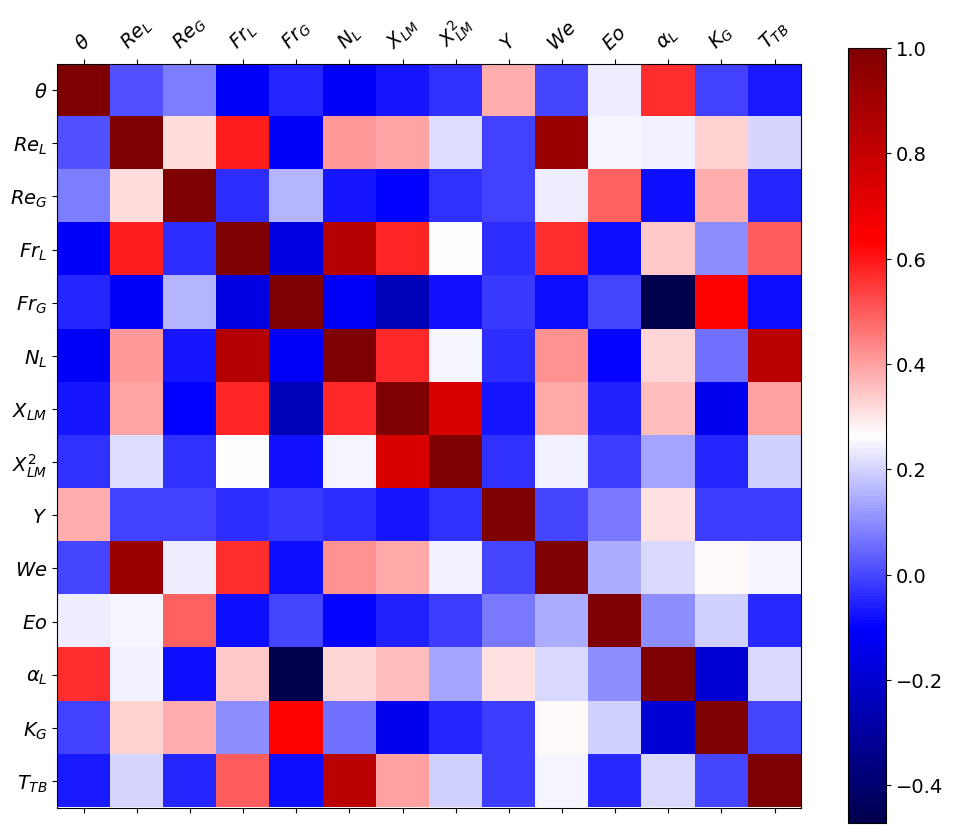

In [18]:
df_corr = df_g.drop(columns=target)
df_corr.columns = [r'$\theta$', r'$Re_{L}$', r'$Re_{G}$', 
                   r'$Fr_{L}$', r'$Fr_{G}$', r'$N_{L}$', 
                   r'$X_{LM}$', r'$X_{LM}^2$', r'$Y$', 
                   r'$We$', r'$Eo$', r'$\alpha_{L}$', 
                   r'$K_{G}$', r'$T_{TB}$']


fig = plt.figure(figsize=(12, 10), dpi=100)
plt.matshow((df_corr).corr(), fignum=fig.number, cmap='seismic')

plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

fig.savefig(f'Plots/Others/CorrMat.png', dpi=fig.dpi, bbox_inches='tight')

## Specific BoxPlots

Here one can use any feature of the dataset in order to generate boxplots. (Mainly for the article)

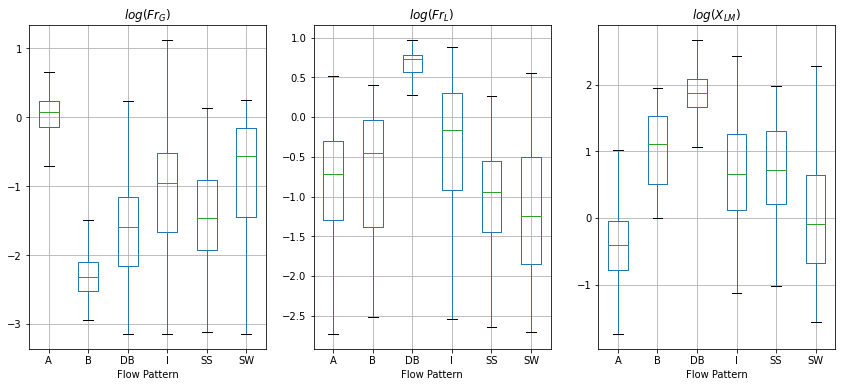

In [19]:
df_ALL = pd.concat([df_log, df_s, df_g, df_b], axis=1)
df_ALL = df_ALL.loc[:,~df_ALL.columns.duplicated()]

to_plot_features = ["log(FrG)", "log(FrL)", "log(X_LM)"]

fig, axes = plt.subplots(nrows=1, ncols=len(to_plot_features), figsize=(14, 6)) 
for quantity, i in zip(to_plot_features, range(len(to_plot_features))):
    df_ALL[[quantity, target]].boxplot(by=target, 
                                           showfliers=False, 
                                           ax=axes[i])
    axes[i].set_xlabel("Flow Pattern")
    fig.suptitle('')

axes[0].set_title(r"$log(Fr_{G})$")
axes[1].set_title(r"$log(Fr_{L})$")
axes[2].set_title(r"$log(X_{LM})$")

    

fig.savefig(f'Plots/BoxPlots/FE.png', dpi=fig.dpi, bbox_inches='tight')

In [20]:
boxplot_quant = ["log(FrG)", "log(FrL)", "Ang"]

fig = make_subplots(rows=1, cols=len(boxplot_quant),
                subplot_titles=[r"$log(Fr_{G})$", r"$log(Fr_{L})$", r"$\theta$",]
                )


for i, q in enumerate(boxplot_quant, start=1):
    for Pattern in df_ALL['Flow_label'].value_counts().index:
        fig.add_trace(go.Box(name=Pattern, y=df_ALL.loc[df_ALL["Flow_label"]==Pattern][q], 
                             line_color='#186ADE'), row=1, col=i)

for i, q in enumerate(boxplot_quant, start=1):
    fig.update_xaxes(title_text="Flow pattern", row=1, col=i, showgrid=True, gridcolor="grey", linecolor='black', mirror=True)
    fig.update_yaxes(row=1, col=i, showgrid=True,  gridcolor="grey", linecolor='black', mirror=True)

fig.update_layout(    
    width=1000,
    height=500,
    showlegend=False,
    title = "Boxplots of relevant features",
    paper_bgcolor='rgb(239,239,239)',
    plot_bgcolor='rgb(255,255,255)'
)

fig.write_image(f'Plots/Others/BoxPlots.png', scale=2)
fig.show()

ValueError: 
The orca executable is required in order to export figures as static images,
but the executable that was found at '/usr/bin/orca'
does not seem to be a valid plotly orca executable. Please refer to the end of
this message for details on what went wrong.

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python

The error encountered is that unexpected output was returned by the command
    $ /usr/bin/orca --help

b'Usage: orca [-h] [-v] [-r] [-s] [-l] [-e OPTION] [-d OPTION] [-p NAME]\n            [-u DIR] [--debug-file FILE] [--debug]\n\nOptional arguments:\n  -h, --help                   Show this help message and exit\n  -v, --version                3.36.2\n  -r, --replace                Replace a currently running instance of this\n                               screen reader\n  -s, --setup                  Set up user preferences (GUI version)\n  -l, --list-apps              Print the known running applications\n  -e OPTION, --enable OPTION   Force use of option\n  -d OPTION, --disable OPTION  Prevent use of option\n  -p NAME, --profile NAME      Load profile\n  -u DIR, --user-prefs DIR     Use alternate directory for user preferences\n  --debug-file FILE            Send debug output to the specified file\n  --debug                      Send debug output to debug-YYYY-MM-DD-\n                               HH:MM:SS.out\n\nReport bugs to orca-list@gnome.org.\n'


## Principal Component Analysis

Now that the basic data analysis is concluded (missing values, cateogricals, variables distribution etc) we can now move to more "advanced" techniques for data visualization such as PCA and t-SNE. From now on the graphs are on plotly.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
X, y = df_g[features_g].values, df_g[target].values.ravel()

In [ ]:
pca = PCA()
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
df_PCA = pd.DataFrame(data=np.column_stack((X, y)))

explained = pca.explained_variance_ratio_
pc = [x for x in range(len(explained))]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pc, 
                         y=explained,
                         mode='lines',
                         name='Single Component'))
fig.add_trace(go.Scatter(x=pc, y=explained.cumsum(),
                    name='Cumulative'))
fig.add_annotation(x=2, y=explained.cumsum()[2],
            text=f"{round(explained.cumsum()[2], 3)}",
            showarrow=True,
            yshift=0)

fig.update_layout(
    title="PCA results",
    xaxis_title="Principal Component",
    yaxis_title="Variance",
)
fig.write_image("Plots/DimensionalityReduction/PCA_variance.png", scale=2)
fig.show()

In [ ]:
def plot_pca(components : tuple):
    
    '''
    Cast the 2D plot between 2 principal components.
    Of course this can be done with scatter matrixes,
    but I prefer much bigger figures.
    Plot is saved in Plots/DimensionalityReduction
    Input: 
        tuple :                    index of the PCs
    Output:
        Plot of the two components
    '''
    
    assert len(components)==2, "Only 2 dimension can be used for this plot"

    fig = px.scatter(df_pca, x=f'PC {components[0]}', y=f'PC {components[1]}',
                     color='Flow Pattern', hover_data={f'PC {components[0]}':False,
                                                       f'PC {components[1]}':False,
                                                       'Flow Pattern':True})


    fig.update_traces(marker=dict(size=6,
                                  line=dict(width=1,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))

    fig.update_layout(width=800,
                      height=600,
                      legend={'itemsizing': 'constant'})
    fig.update_layout(legend=dict(font = dict(family = "Courier", size = 15, color = "black")),
                      legend_title = dict(font = dict(family = "Flow Pattern", size = 15)))
    
    fig.write_image(f"Plots/DimensionalityReduction/PCA_{components[0]}{components[1]}.png", scale=2)

    return fig.show()

In [ ]:
df_pca = pd.DataFrame({f'PC {component}': X_pca[:, component] for component in pc})
df_pca['Flow Pattern'] = df_b[target].reset_index(drop=True) 
plot_pca((0,1))

In [ ]:
plot_pca((1,2))

## t-SNE

Finally, we can use t-SNE to properly reduce the dimensionality of the data while preserving the relative euclidean distance between the various points

In [ ]:
from sklearn import manifold

In [ ]:
def plot_tsne(components=2, perplexity=150):
    
    '''
    Simple function to perfom the t-SNE given a 
    number of components and a perplexity.
    Plot is saved in Plots/DimensionalityReduction
    
    Input:
        int (2 or 3)         components
        int                  perplexity
    
    Output:
        plotly object        t-SNE plot
    '''
    
    method = manifold.TSNE(n_components=components, 
                           init='pca', 
                           perplexity=perplexity, 
                           random_state=42)
    
    X_tSNE = method.fit_transform(X_scaled)
    df_tSNE = pd.DataFrame({f't-SNE {c}' : X_tSNE[:, c] for c in range(components)})
    df_tSNE['Flow Pattern'] = df_b['Flow_label'].reset_index(drop=True) 
    
    if components==3:
        
        size=3
        width=2
        
        fig = px.scatter_3d(df_tSNE, x='t-SNE 0', y='t-SNE 1', z='t-SNE 2',
                  color='Flow Pattern', hover_data={'t-SNE 0':False,
                                                    't-SNE 1':False,
                                                    't-SNE 2':False,
                                                    'Flow Pattern':True})
    else:
        
        size=6
        width=1

        fig = px.scatter(df_tSNE, x='t-SNE 0', y='t-SNE 1', color='Flow Pattern', 
                                     hover_data={'t-SNE 0':False,
                                                 't-SNE 1':False,
                                                 'Flow Pattern':True})
    fig.update_traces(marker=dict(size=size, line=dict(width=width,
                                  color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    
    
    fig.update_layout(legend=dict(font=dict(family = "Courier", 
                                            size = 15, 
                                            color = "black")),
                      legend_title = dict(font = dict(family = "Flow Pattern", size = 15)))  
    
    fig.update_layout(width=800,
                      height=600,legend={'itemsizing': 'constant'})
    fig.write_image(f"Plots/DimensionalityReduction/tSNE_{components}.png", scale=2)
    
    return fig.show()


In [ ]:
plot_tsne(components=3)

In [ ]:
plot_tsne(components=2, perplexity=500)

## Parallel-Coordinates Plot

The last step in this exploratory data analysis is the parallel coordinates plot. This plot is usefull to understand the relative importance of some features. Here we can see that as expected, the SS regime only exists for small tilt angles, that I is everywhere, and will likely be the regime with the lower recall.

In [ ]:
di = {0: 'A', 1: 'DB', 2: 'I', 3: 'SW', 4: 'SS', 5:'B'}
dimensions = list([dict(label='ID', values=df_ALL['ID']),
                   dict(label='Ang', values=df_ALL['Ang']),
                   dict(label='log(FrL)', values=df_ALL['log(FrL)']),
                   dict(label='log(FrG)', values=df_ALL['log(FrG)']),
                   dict(label='HU', values=df_ALL['HU']),
                   dict(range=[0,df_g['Flow_label'].max()],
                       tickvals = list(di.keys()), ticktext =list(di.values()),
                       label='Flow Regime', values=df_g['Flow_label']),
                  ])

fig = go.Figure(data=go.Parcoords(line = dict(color = df_g['Flow_label'], 
                                colorscale = 'inferno'), dimensions=dimensions))
fig.show()

## Save the Dataset

We can now proceed to save the various dataset, from the bronze (raw) to the gold (preprocessed)

In [21]:
df_b.to_csv('Data/Train_bronze.csv', index=False)
df_s.to_csv('Data/Train_silver.csv', index=False)
df_g.to_csv('Data/Train_gold.csv', index=False)